In [1]:
import sys
import os
import numpy as np
import MDAnalysis as mda
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
cur_path1 = os.getcwd()

In [3]:
q_star_arr = ["100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200" ]
# q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000","1100", "1200", "1300", "1400","1500", "1600", "1700", "1800", "1900", "2000", "2100", "2200" ]

In [4]:
#Get atom_pos for each universe for each time frame (N, timeframe, positions(M molecules,3))
atom_pos = []
u_list = []
index_file = "solid_like_atoms.index"


for i in q_star_arr:
    work_path = cur_path1 + "\\" +i
    os.chdir(work_path)
    u = mda.Universe("bias.gro","bias_whole.xtc")
    u_list += [u]
    
    solid_ndx = []
    df = open(index_file, "r+")
    for line in df.readlines():
        solid = np.fromstring(line, dtype=int, sep=' ') -1
        solid_ndx += [solid]
        
    print('there are %s time frames in %s q_star' %(len(solid_ndx), i))
    
    solid_pos = []
    for j in range(len(solid_ndx)):
        solid = solid_ndx[j]
        solid_poss = np.zeros([len(solid), 3])
        for k in range(len(solid)):
            solid_poss[k] = u.atoms[solid[k]].position
        solid_pos += [solid_poss]

    
    atom_pos += [solid_pos]
    
atom_pos = atom_pos[:-1]
ref_pos = atom_pos[-1]

there are 251 time frames in 100 q_star
there are 251 time frames in 200 q_star
there are 251 time frames in 300 q_star
there are 251 time frames in 400 q_star
there are 251 time frames in 500 q_star
there are 251 time frames in 600 q_star
there are 251 time frames in 700 q_star
there are 251 time frames in 800 q_star
there are 251 time frames in 900 q_star
there are 251 time frames in 1000 q_star
there are 251 time frames in 1100 q_star
there are 251 time frames in 1200 q_star
there are 251 time frames in 1300 q_star
there are 251 time frames in 1400 q_star
there are 251 time frames in 1500 q_star
there are 251 time frames in 1600 q_star
there are 251 time frames in 1700 q_star
there are 251 time frames in 1800 q_star
there are 251 time frames in 1900 q_star
there are 251 time frames in 2000 q_star
there are 251 time frames in 2100 q_star
there are 251 time frames in 2200 q_star


In [5]:
t_atom_position = atom_pos[0]

In [6]:
#get surface atom's position
# surface_pos is the key

u = u_list[-1]
ref_indx = "surface.ndx"

sf = open(ref_indx, "r+")
surface_ndx = []
for line in sf.readlines():
    surface_ndx += [np.int(line)]
surface_ndx = np.array(surface_ndx)

#convert to python scheme
surface_ndx = surface_ndx - 1

surface_pos = np.zeros([len(surface_ndx), 3])
for i in range(len(surface_ndx)):
    surface_pos[i] = u.atoms[surface_ndx[i]].position
print('there are %s surface atoms in this simulation.' % surface_pos.shape[0])

there are 189 surface atoms in this simulation.


In [7]:
# This code is written by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

class density_near_surface:
    '''
    Calculates density near surface and returns heavy atoms that satisfies density > cutoff
    
    Args:
    atom_pos(list): atom position of interest per simulation, time (# of simulation, # time frame, (# of atom, 3))
    ref_pos(list): reference atom position of interest for one simulation. (# time frame, (# of atom, 3))
    surface_pos(numpy.ndarray): surface atom position (# of surface atoms, 3)
    box(numpy.ndarray): simuation box size (3,)
    radius_cutoff(float): cutoff for union of sphere's radius
    density_cutoff(float): cutoff for density
    
    Density counts number of ice molecules surrounded by a sphere centering i'th heavy atom's position and radius as radius_cutoff  

    '''
    
    def __init__(self, atom_pos, ref_pos, surface_pos, box, surface_index, radius_cutoff, density_cutoff=0.5):
        self.atom_pos = atom_pos
        self.ref_pos = ref_pos
        self.surface_pos = surface_pos
        self.box = box
        self.radius_cutoff = radius_cutoff
        self.density_cutoff = density_cutoff
        self.surface_index = surface_index
        
        #for reference
        self.ref_solid_count = np.zeros((len(self.surface_pos), len(self.ref_pos))) # (# of surface atom, # of data frame)
        self.avg_ref_solid_count = np.zeros(len(self.surface_pos),)
        
        #for real
        self.solid_count = [] # (# of data frame, # of surface atoms, # of simulations)
        self.avg_solid_count = []  #( # of surface atoms, # of simulations)
        
        #if i th surface atom;s density is greater than cutoff, it is 1, if not 0
        self.true_density = [] #(# of simulations, # of surface atoms)
        # index of surface atom where density is greater than cutoff
        self.surface_density_ndx = [] #(# of simulations, # of surface atoms)
        
        
    def get_ref_density(self):
        # i for time frame
        for i in range(len(self.ref_pos)):
            ref_poss = self.ref_pos[i]
            dist = np.abs(ref_poss[:, np.newaxis, :] - self.surface_pos)
            cond = 1*(dist > self.box/2)
            dist = abs(cond*self.box - dist)
            dist = np.sum(dist*dist, axis = 2).T
            dist = np.sqrt(dist)
            
            self.ref_solid_count[:,i] = np.count_nonzero( dist < self.radius_cutoff , axis = 1)

        self.avg_ref_solid_count = np.average(self.ref_solid_count, axis = 1)
        
        return self.avg_ref_solid_count
    
    def get_density(self):
        # i for simulation
        for i in range(len(self.atom_pos)):
            solid_countt = np.zeros((len(self.surface_pos), len(self.ref_pos)))
            t_atom_position = self.atom_pos[i]
            
            #j for time frame
            for j in range(len(t_atom_position)):
                atom_poss = t_atom_position[j]
                dist = np.abs(atom_poss[:, np.newaxis, :] - self.surface_pos)
                cond = 1*(dist > self.box/2)
                dist = abs(cond*self.box - dist)
                dist = np.sum(dist*dist, axis = 2).T
                dist = np.sqrt(dist)
                
                solid_countt[:,j] = np.count_nonzero( dist < self.radius_cutoff, axis = 1)
            self.avg_solid_count += [np.average(solid_countt, axis = 1)]
        
        
        return self.avg_solid_count
    
    def compare_density(self):
        # i for simulation
        for i in range(len(self.atom_pos)):
            density = self.avg_solid_count[i]/self.avg_ref_solid_count
            true_density = density > self.density_cutoff
            true_density = true_density.astype(int)
            surface_index = true_density*self.surface_index
            surface_index = surface_index[np.nonzero(surface_index)]
            
            self.true_density += [true_density]
            self.surface_density_ndx += [surface_index]
        
        return self.true_density, self.surface_density_ndx



In [8]:
dnf = density_near_surface(atom_pos, ref_pos, surface_pos, np.array([64.6204,   79.5328,   59.6496]), surface_ndx, 12, 0.5)

In [9]:
avg_ref_solid_count = dnf.get_ref_density()

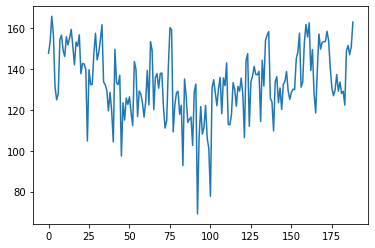

In [10]:
plt.plot(avg_ref_solid_count)

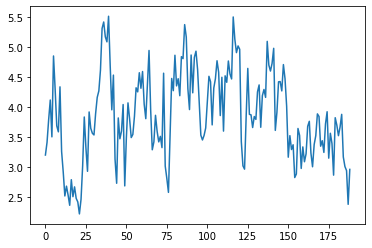

In [11]:
avg_solid_count = dnf.get_density()
plt.plot(avg_solid_count[0])

21


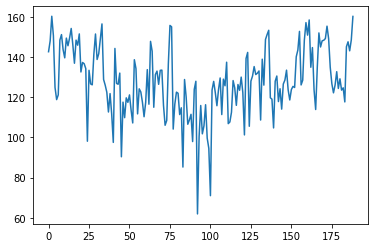

In [12]:
print(len(avg_solid_count))
plt.plot(avg_ref_solid_count - avg_solid_count[1])

In [13]:
true_density, true_surface_index = dnf.compare_density()

In [19]:
np.savetxt('icy_heavy_atoms.txt',true_surface_index[-1], fmt='%s')

In [18]:
true_surface_index[-1]

array([   6,   13,   14,   19,   23,   26,   33,   35,   39,   42,   45,
         49,   50,   52,   55,   56,   57,   59,   61,   66,   71,   75,
         78,   88,   95,   99,  102,  105,  107,  110,  113,  130,  134,
        137,  138,  140,  145,  149,  154,  164,  171,  175,  181,  185,
        195,  202,  207,  211,  212,  231,  234,  240,  249,  250,  254,
        269,  271,  275,  287,  291,  311,  315,  327,  328,  332,  355,
        356,  369,  371,  373,  394,  398,  403,  414,  417,  420,  425,
        440,  444,  445,  456,  460,  473,  480,  484,  490,  494,  512,
        516,  528,  529,  541,  546,  550,  555,  560,  562,  566,  569,
        579,  590,  591,  592,  603,  607,  627,  631,  639,  643,  644,
        648,  667,  670,  673,  676,  690,  691,  712,  714,  716,  723,
        735,  736,  738,  753,  756,  757,  758,  769,  773,  786,  793,
        797,  808,  809,  810,  812,  830,  834,  846,  847,  866,  869,
        870,  872,  874,  875,  877,  879,  882,  8

In [32]:
#Save file

p = 0
for i in q_star_arr[:-1]:
    work_path = cur_path1 + "\\" +i
    os.chdir(work_path)
    tsi = true_surface_index[p]
    p += 1
    
    print(p)
    
    if len(tsi) == 0:
        continue
    else:
        np.savetxt('icy_heavy_atoms.txt',tsi, fmt='%s')    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [31]:
len(q_star_arr)

22

(0,)


In [21]:
true_surface_index

[array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([287, 315, 456, 473, 480, 484, 603, 627, 631, 797]),
 array([ 33,  35,  39,  42,  45,  49,  50,  52,  55,  56,  57, 164, 171,
        175, 181, 185, 195, 311, 327, 332]),
 array([ 23,  26,  33,  39, 140, 145, 149, 154, 164, 171, 175, 275, 287,
        291, 311, 315, 327, 456, 460, 473, 480, 484, 603, 607, 627, 631,
        797]),
 array([145, 149, 154, 164, 171, 175, 269, 275, 287, 291, 311, 315, 327,
        440, 444, 445, 456, 460, 473, 480, 484, 490, 579, 590, 591, 603,
        607, 627, 631, 639, 753, 756, 757, 758, 769, 773, 786, 793, 797,
        808, 809, 810, 919, 925, 928, 931, 933, 943, 948, 955, 959, 963]),
 array([ 66,  75,  88,  95,  99, 102, 105, 181, 185, 195, 202, 207, 212,
        327, 328, 332, 355, 356, 369, 373, 480, 490, 494, 512, 516, 627,
        639, 643, 644, 648, 667, 670, 673, 676, 690, 691, 808, 809, 810,
        812, 830, 834, 970, 971, 972, 976, 988, 

In [34]:
--------------------------------------------practice----------------------------

34

In [19]:
#get solid atom's position for 2200

u = u_ref

solid_ndx_2200 = []
df = open("solid_like_atoms.index", "r+")
for line in df.readlines():
    solid = np.fromstring(line, dtype=int, sep=' ') -1
    solid_ndx_2200 += [solid]

print('there are %s time frames' % len(solid_ndx_2200))
solid_pos = []
for i in range(len(solid_ndx_2200)):
    solid = solid_ndx_2200[i]
    solid_poss = np.zeros([len(solid), 3])
    for j in range(len(solid)):
        solid_poss[j] = u.atoms[solid[j]].position
    solid_pos += [solid_poss]
    
#key is to get solid_pos

there are 251 time frames


In [14]:
#get surface atom's position
u = u_ref

sf = open("surface.ndx", "r+")
surface_ndx = []
for line in sf.readlines():
    surface_ndx += [np.int(line)]
surface_ndx = np.array(surface_ndx)

#convert to python scheme
surface_ndx = surface_ndx - 1

surface_pos = np.zeros([len(surface_ndx), 3])
for i in range(len(surface_ndx)):
    surface_pos[i] = u_ref.atoms[surface_ndx[i]].position
print('there are %s surface atoms in this simulation.' % surface_pos.shape[0])

#key is to get surface_pos

there are 189 surface atoms in this simulation.


In [15]:
#lets get distance between solid_pos and surface_pos for all time frame
box = np.array([64.6204,   79.5328,   59.6496])

solid_count = np.zeros((len(surface_pos), len(solid_pos)))
print('solid_count',solid_count.shape)
for i in range(len(solid_pos)):
    solid_poss = solid_pos[i]
    dist = np.abs(solid_poss[:, np.newaxis, :] - surface_pos)
    cond = 1*(dist > box/2)
    dist = abs(cond*box -dist)
    dist = np.sum(dist*dist, axis = 2).T
    dist = np.sqrt(dist)

    
    solid_count[:,i]= np.count_nonzero( dist < 12 , axis = 1)





solid_count (189, 251)


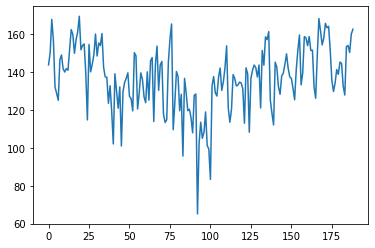

In [16]:
avg_solid_count = np.average(solid_count, axis = 1)
std_solid_count = np.std(solid_count, axis = 1)

figure
plt.plot(avg_solid_count)

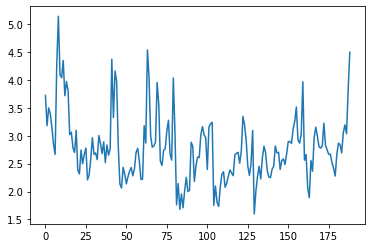

In [17]:
figure
plt.plot(std_solid_count)

In [ ]:
hello = u_list[0]
a = hello.select_atoms("index 1031")

In [ ]:
solid_pos[0]

In [ ]:
surface_pos